# Notebook recap 
-----


This notebook does not really consist of an the application of 3 data engineering tasks that are asked by the interview : 
1. Download and read the file: product_catalog.csv locally
2. Transform the file from CSV to Parquet format locally
3. Separate the valid rows from the invalid ones into two separate files: the business wants only the product with an image but wants to archive the invalids rows 

The resolution of the up mentioned tasks can be checked in the python script. But, after leading a summary analysis on the distribution of values for every columns it seemed like the file had inconsistencies in it's data. 

**Pain issue : some images are duplicated but handle different category_ids, year_release, descriptions, comments, currencies and brands.**

In [1]:
import pandas as pd 
import numpy as np 

df = pd.read_csv('../product_catalog.csv')
df_valid = df[~df.image.isna()]
df_archived = df[df.image.isna()]

In [230]:
# needed to install fastparquet or pyarrow for conversion engine, example of how to bring it to parquet through notebook
# df_valid.to_parquet('../df_valid.parquet', engine='fastparquet')
# df_archived.to_parquet('../df_archived.parquet', engine='fastparquet')

## Pain issue showcase 
----

In [2]:
df_valid.drop_duplicates().shape, df_valid.drop_duplicates('image').shape

((740, 7), (516, 7))

In [6]:
df_valid.drop_duplicates('image').shape

(516, 7)

In [3]:
first_duplicate = df_valid[df_valid.image.duplicated(keep='last')].image.loc[0]
duplicate_image_example = [i for i in df_valid['image'].index if df_valid['image'].loc[i] == first_duplicate]

df_valid.loc[duplicate_image_example]

,brand,category_id,comment,currency,description,image,year_release
0,Toshiba,71,NaN,NOK,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1993
278,Samsung,83,NaN,CNY,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2001
422,Lenovo,42,Curabitur gravida nisi at nibh. In hac habitas...,ARS,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2000
493,HP,13,In hac habitasse platea dictumst. Aliquam augu...,CNY,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2010


**How do we proceed? Should we only take the images that are not duplicated ?**

## Documentation about other investigations, per column
----

Investigating other rows to observe inconistencies and have other possibles rows to alert about, or archive, they have not revealed any noticible inconsistency. 

In [233]:
df.head()

,brand,category_id,comment,currency,description,image,year_release
0,Toshiba,71,NaN,NOK,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1993
1,HP,99,Suspendisse accumsan tortor quis turpis.,PEN,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",1988
2,Acer,69,Donec dapibus. Duis at velit eu est congue ele...,IDR,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2010
3,HP,62,NaN,CNY,Female,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2008
4,Dell,48,Vivamus in felis eu sapien cursus vestibulum. ...,CNY,Male,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",2013


In [234]:
df.isna().sum()

brand             0
category_id       0
comment          71
currency          0
description     163
image           260
year_release      0
dtype: int64

In [235]:
get_perc = lambda x: round(x,2)*100

def get_comp(col):
    """
    returns distributions of values of a given column indicated in args between 2 dataframes, dfValid and dfArchived 
    """
    without_nan_images  = (df_valid[col].value_counts() / df_valid.shape[0]).rename('without_nan_images')
    with_nan_images = (df_archived[col].value_counts() / df_archived.shape[0]).rename('with_nan_images')
    return pd.concat([without_nan_images, with_nan_images], axis=1).apply(get_perc)

Comparing distribution of Nans between df with and without Nans (dfArchived = with nan images, dfValid = without nan images)

In [236]:
pd.concat([(df_valid.isna().sum() / df_valid.shape[0]).rename('without_nan_images'), 
           (df_archived.isna().sum() / df_archived.shape[0]).rename('with_nan_images')], axis=1).apply(get_perc)

,without_nan_images,with_nan_images
brand,0.0,0.0
category_id,0.0,0.0
comment,7.0,7.0
currency,0.0,0.0
description,15.0,19.0
image,0.0,100.0
year_release,0.0,0.0


### Brand
----

Comparing distrubution of brands between dfValid and dfArchived

In [237]:
get_comp('brand')

,without_nan_images,with_nan_images
HP,18.0,17.0
Toshiba,17.0,15.0
Samsung,17.0,18.0
Acer,17.0,15.0
Dell,16.0,19.0
Lenovo,15.0,15.0


### Category_id 
----

In [238]:
get_comp('category_id').head(5)

,without_nan_images,with_nan_images
1,1.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,NaN
5,1.0,2.0


 not really interpretable so substracted both columns to only have a differences value col that is described beneath

In [239]:
get_comp('category_id').apply(lambda x: x.without_nan_images 
                                        - x.with_nan_images, 
                              axis=1).describe().loc['min':'max']

min   -2.0
25%   -1.0
50%    0.0
75%    0.0
max    2.0
dtype: float64

In [131]:
get_comp('category_id').apply(lambda x: x.without_nan_images - x.with_nan_images, axis=1).var()

0.6625486158773742

There are no real differences here, as the largest differences are about 2 % between distribution of particular categories and variance is about 0.66

### Currency
----

Comparing distrubution of currencies between dfValid and dfArchived

In [86]:
getComp('currency').head(10)

,withoutNanImages,withNanImages
CNY,21.0,17.0
EUR,11.0,7.0
IDR,10.0,12.0
RUB,7.0,7.0
PHP,4.0,6.0
BRL,4.0,3.0
PLN,2.0,5.0
SEK,2.0,2.0
UAH,2.0,2.0
CZK,2.0,1.0


### Description
-----

Nothing to say here really, except that the distribution of genders is the same accross the dataframes, this is validated given the fact that the nans for both dfs are similar for this column (15% and 19%). Also this is important to sanity check, you wouldn't want to notify before validating only males or females. 

In [121]:
getComp('description')

,withoutNanImages,withNanImages
Female,43.0,41.0
Male,42.0,40.0


### Year release
----

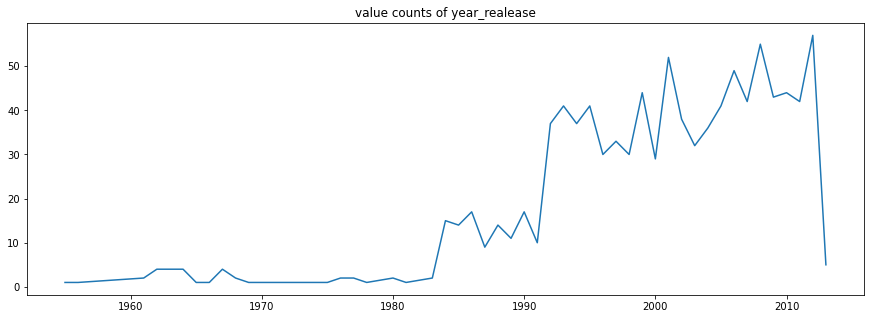

In [125]:
df.year_release.value_counts().sort_index().plot(figsize=(15,5), title='value counts of year_realease');

In [5]:
df.image.value_counts().value_counts()

1    346
2    123
3     40
4      7
Name: image, dtype: int64

### Comments 
----

In [145]:
def getWordVC(dataframe):
    '''
    Returns the value count of the number of words in the comment section of the given dataframe
    '''
    numberOfWords = dataframe[~dataframe.comment.isna()].comment.apply(lambda x: len(x.split()))
    return numberOfWords.value_counts().sort_index()

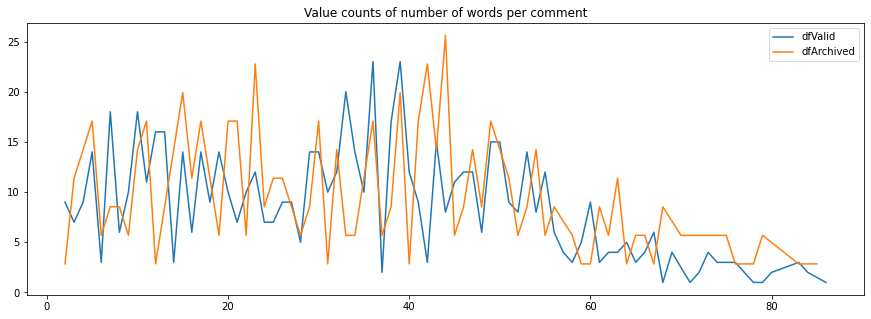

In [152]:
ratio = dfValid.shape[0] / dfArchived.shape[0] # Compares for dataframes of same scale

title = 'Value counts of number of words per comment'
getWordVC(dfValid).rename('dfValid').plot(figsize=(15,5), legend=True, title=title);
getWordVC(dfArchived).rename('dfArchived').apply(lambda x: x*ratio).plot(figsize=(15,5), legend=True);

In [216]:
dfValid.drop_duplicates('comment').shape, dfValid[~dfValid.comment.isna()].shape

((555, 7), (688, 7))